# **Imports**

---



In [ ]:
!pip install easyocr
!pip install torch transformers

In [ ]:
# Basic utilities
import os
import string
import math
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import zlib
import copy
# Google stuff
import google.colab as colab
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split as TorchRandomSplit
#from torchvision.transforms import v2 as transforms
import torchvision.transforms as transforms
from torchvision import models
import torch.optim.lr_scheduler as lr_scheduler
# Image libraries
from PIL import Image, ImageFilter
import cv2
# Reading text from image
import easyocr
# Other
import transformers
from matplotlib import pyplot as plt
# SKLearn
import sklearn
import sklearn.decomposition

# **Parameters, tools**

---



## Move to correct location

In [ ]:
colab.drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Magisterka
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Magisterka
 FFTResnet
 images
 output.json
'PyTorch Magisterka.ipynb'
 raw
'RD RESNET50 + DistilRoBERTa, resize bez paddingu.history'
'RD RESNET50 + DistilRoBERTa, uśrednianie cech.history'
'RD RESNET50 + DistilRoBERTa, wartość maksymalna cech.history'
'RD VGG19 + DistilRoBERTa, resize bez paddingu.history'
'RD VGG19 + DistilRoBERTa, uśrednianie cech.history'
'RD VGG19 + DistilRoBERTa, wartość maksymalna cech.history'
'RESNET50 + DistilRoBERTa, nieważona funkcja straty.history'
'TF Magisterka.ipynb'
'Wyniki etc.'


## Main parameters

In [ ]:
# Image parameters
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3 # must be either 1 (grayscale) or 3 (RGB). Warning: I'm not checking whether you set this to correct value
IMG_FILTERS = [ ImageFilter.MedianFilter(size=3) ] # preprocessing image

# Dataset
TRAIN_VS_VAL_SPLIT = 0.75 # must belong to 0..1, 0.8 -> 80% images go to train set
RANDOM_SEED = 7983
#LABELS = ["realistic_style","cartoon_style","meme","advert","informative","text","artwork","suggestive","porn","sexism","racism","slander","crude","gore","violent","humorous","disturbing","wholesome"] # list of labels
LABELS = ["realistic_style", "cartoon_style", "meme", "text", "artwork", "suggestive", "porn", "humorous"]
IMG_HEADER = "filename"

# Text
EASYOCR_READER = easyocr.Reader(["en"]) # you may change/add supported languages here. Note that changing language to any other than English would require more code changing than that (model, preprocessing etc)
TEXT_HEADER = "extracted_text"
MAX_TOKENS = 128

# PyTorch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
FEATURES_SIZE = 512

# Paths etc.
RAW_DATASET_CSV = "raw/dataset.csv"
RAW_DATASET_IMGS = "raw"
PROCESSED_DATASET_JSON = "output.json"
PROCESSED_DATASET_IMGS = "images"
TMP_DIR = ".tmp"

## Transforms - Image augmentation

In [ ]:
AUGMENTATION = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(1, 1.1)),
])

## Tools

In [ ]:
class Tools:
  def __init__(self, batch_size, img_height, img_width, img_channels, filters, labels, easyocr_reader, augmentation):
    self.batch_size = batch_size
    self.img_height = img_height
    self.img_width = img_width
    self.img_channels = img_channels
    self.filters = filters
    self.labels = labels
    self.easyocr_reader = easyocr_reader
    self.augmentation = augmentation
  def __resize_with_padding(dummy, pil_image, img_height, img_width, mode, interpolation_algorithm = Image.LANCZOS, padding_color = "black"):
    original_width, original_height = pil_image.size
    aspect_ratio = original_width / original_height
    if img_width / img_height > aspect_ratio:
        new_width = int(img_height * aspect_ratio)
        resized_image = pil_image.resize((new_width, img_height), resample = interpolation_algorithm)
    else:
        new_height = int(img_width / aspect_ratio)
        resized_image = pil_image.resize((img_width, new_height), resample = interpolation_algorithm)
    padded_image = Image.new(mode, (img_width, img_height), color=padding_color)
    position = ((img_width - resized_image.width) // 2, (img_height - resized_image.height) // 2)
    padded_image.paste(resized_image, position)
    return padded_image
  def FreezeModel(self, model):
    for param in model.parameters():
      param.requires_grad = False
  def PilMode(self):
    return "L" if self.img_channels == 1 else "RGB"
  def ProcessImage(self, pil_image):
    image = pil_image
    image = image.convert(self.PilMode())
    for filter in self.filters: image = image.filter(filter)
    return self.__resize_with_padding(image, self.img_height, self.img_width, self.PilMode())
  def AugmentImage(self, image):
    return self.augmentation(image)
  def ProcessText(self, text): # no need
    return text
  def ExtractText(self, pil_image):
    numpy_image = np.array(pil_image)
    extracted_text = " ".join(self.easyocr_reader.readtext(numpy_image, paragraph=True, detail = 0))
    return self.ProcessText(extracted_text) if extracted_text else " " # returning empty string would break CSV files
  def Entropy(dummy, x):
    if x <= 0.0: return 0.0
    if x >= 1.0: return 0.0
    l = x * math.log2(x)
    p = (1.0-x) * math.log2(1.0-x)
    return -(l+p)

In [ ]:
TOOLS = Tools(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, IMG_FILTERS, LABELS, EASYOCR_READER, AUGMENTATION)

## Misc

In [ ]:
# Used to speed up loading images

def SaveBin(ob, filename):
  with open(filename, "wb") as handle:
    dump = pickle.dumps(ob)
    dump = zlib.compress(dump)
    handle.write(dump)

def LoadBin(filename):
  with open(filename, "rb") as handle:
    dump = handle.read()
    dump = zlib.decompress(dump)
    return pickle.loads(dump)

In [ ]:
def stats_to_latex(stats_dict, table_caption="Statistics Table", table_label="tab:stats"):
    """
    Converts a dictionary of statistics into LaTeX table code.

    Parameters:
    - stats_dict: dict, the dictionary containing statistics where 'key' is the name of the variable and 'value' is the statistic.
    - table_caption: str, caption for the LaTeX table.
    - table_label: str, label for referencing the table in LaTeX.

    Returns:
    - str, LaTeX table code.
    """
    # Create the LaTeX table header
    latex_code = "\\begin{table}[ht]\n"
    latex_code += "\\centering\n"
    latex_code += "\\begin{tabular}{|c|c|}\n"
    latex_code += "\\hline\n"
    latex_code += "Statistic & Value \\\\\n"
    latex_code += "\\hline\n"

    # Add each statistic to the table
    for key, value in stats_dict.items():
        latex_code += f"{key} & {value} \\\\\n"
        latex_code += "\\hline\n"

    # Close the LaTeX table
    latex_code += "\\end{tabular}\n"
    latex_code += f"\\caption{{{table_caption}}}\n"
    latex_code += f"\\label{{{table_label}}}\n"
    latex_code += "\\end{table}\n"

    return latex_code

# **Pretrained models, PCA model**

---



## Image

In [ ]:
class VGG19(nn.Module):
  def __init__(self):
    super(VGG19, self).__init__()
    self.vgg = models.vgg19(weights = models.VGG19_Weights.IMAGENET1K_V1)
    self.vgg.classifier = nn.Sequential(*list(self.vgg.classifier.children())[:-2])
    TOOLS.FreezeModel(self.vgg)

  def normalize(self, image):
    return models.VGG19_Weights.IMAGENET1K_V1.transforms()(image)

  def forward(self, x):
    self.vgg.eval()
    with torch.no_grad():
      x = self.vgg(x)
      return x

class RESNET50(nn.Module):
  def __init__(self):
    super(RESNET50, self).__init__()
    self.model = models.resnet50(weights = models.ResNet50_Weights.IMAGENET1K_V1)
    self.model.fc = nn.Identity()
    TOOLS.FreezeModel(self.model)

  def normalize(self, image):
    return models.ResNet50_Weights.IMAGENET1K_V1.transforms()(image)

  def forward(self, x):
    self.model.eval()
    with torch.no_grad():
      x = self.model(x)
      return x

#IMAGE_MODEL = VGG19().to(DEVICE)
IMAGE_MODEL = RESNET50().to(DEVICE)

## Text

In [ ]:
class DistilRoBERTa(nn.Module):
  def __init__(self, max_tokens):
    super(DistilRoBERTa, self).__init__()
    self.max_tokens = max_tokens
    self.tokenizer = transformers.AutoTokenizer.from_pretrained("distilroberta-base")
    self.model = transformers.AutoModel.from_pretrained("distilroberta-base")
    TOOLS.FreezeModel(self.model)

  def tokenize(self, text):
    return self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=self.max_tokens,
        truncation=True,
        padding='max_length',  # Pad to the fixed length
        return_tensors='pt'  # Return as a PyTorch tensor
    )

  def forward(self, encoding):
    self.model.eval()
    input_ids, attention_mask = encoding['input_ids'].squeeze(1), encoding['attention_mask'].squeeze(1)
    with torch.no_grad():
      _, features = self.model(input_ids = input_ids, attention_mask = attention_mask, return_dict=False)
      return features

class XLNet(nn.Module):
  def __init__(self, max_tokens):
    super(XLNet, self).__init__()
    self.max_tokens = max_tokens
    self.tokenizer = transformers.AutoTokenizer.from_pretrained("xlnet-base-cased")
    self.model = transformers.AutoModel.from_pretrained("xlnet-base-cased")
    TOOLS.FreezeModel(self.model)

  def tokenize(self, text):
    return self.tokenizer(
      text,
      return_tensors='pt',
      max_length=self.max_tokens,
      padding='max_length',
      truncation=True,
      add_special_tokens=True,
    )

  def forward(self, encoding):
    self.model.eval()
    input_ids, attention_mask = encoding['input_ids'].squeeze(1), encoding['attention_mask'].squeeze(1)
    with torch.no_grad():
      outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
      features = outputs.last_hidden_state[:, 0, :]
      return features

TEXT_MODEL = DistilRoBERTa(MAX_TOKENS).to(DEVICE)
#TEXT_MODEL = XLNet(MAX_TOKENS).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## FFT Resnet

In [ ]:
# Do NOT change anything there.
# It was pretrained with these parameters, transforms and so on, it should be used with them aswell.
class PretrainedFFTResnet(nn.Module):
  def __init__(self, num_classes):
    super(PretrainedFFTResnet, self).__init__()
    self.resnet = models.resnet18(pretrained=False, num_classes = num_classes)
    self.resnet.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Normalize((0.5), (0.5)),
    ])
    self.normalization = (0.003469953, 0.00758842, 0.0016209723, 1.8142798) # mag_avg, mag_std, ang_avg, ang_std

  def __fourier_transform(self, img):
      img_tensor = img
      img_tensor = torch.fft.fft2(img_tensor, norm="forward")
      magnitude = torch.abs(img_tensor)
      phase = torch.angle(img_tensor)
      if self.normalization:
        mag_avg, mag_std, ang_avg, ang_std = self.normalization
        magnitude = (magnitude - mag_avg) / mag_std
        phase = (phase - ang_avg) / ang_std
      return torch.cat([magnitude, phase], dim=0)

  def __batched_fourier(self, batch_tensor):
    B = batch_tensor.shape[0]
    results = []
    for i in range(B):
        result = self.__fourier_transform(batch_tensor[i])
        results.append(result)
    batch_result = torch.stack(results)
    return batch_result

  def compute_normalization(self, images): # images should be pillow images
    self.normalization = None
    all_magnitudes = []
    all_phases = []
    for image in images:
      m, p =  self.__fourier_transform(self.normalize(image))
      all_magnitudes.append(m)
      all_phases.append(p)
    all_magnitudes = np.concatenate(all_magnitudes, axis = 0)
    all_phases = np.concatenate(all_phases, axis = 0)
    self.normalization = (np.mean(all_magnitudes), np.std(all_magnitudes), np.mean(all_phases), np.std(all_phases))

  def normalize(self, image):
    return self.transform(image)

  def forward(self, x):
    x = self.__batched_fourier(x)
    return self.resnet(x)

In [ ]:
class FFTResnet(nn.Module):
  def __init__(self):
    super(FFTResnet, self).__init__()
    self.model = PretrainedFFTResnet(200)
    self.model.load_state_dict(torch.load("FFTResnet/model.pth"))
    self.model.resnet.fc = nn.Identity()
    TOOLS.FreezeModel(self.model)

  def normalize(self, image):
    return self.model.normalize(image)

  def forward(self, x):
    self.model.eval()
    with torch.no_grad():
      x = self.model(x)
      return x

FFT_MODEL = FFTResnet().to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## PCA

In [ ]:
class PCA_Transform(nn.Module):
    def __init__(self, n_components, dataloader, feature_extract):
        super(PCA_Transform, self).__init__()
        self.dummy_layer = nn.Linear(10,5)
        TOOLS.FreezeModel(self)
        self.pca = None
        self.__fit(n_components, dataloader, feature_extract)

    def forward(self, x):
      if self.pca is None: raise RuntimeError("PCA transform not fitted to data")
      x = x.cpu().numpy()
      x = self.pca.transform(x)
      x = torch.from_numpy(x)
      x = x.to(next(self.parameters()).device)
      return x

    # feature_extract(data) - function, convert data (tuple provided by dataloader) into feature vector
    def __fit(self, n_components, dataloader, feature_extract):
      features = []
      loop = tqdm(dataloader)
      with torch.no_grad():
          for data in loop:
              output = feature_extract(data)
              output = output.view(output.size(0), -1)  # Flatten the features if not already
              features.append(output.cpu().numpy())  # Move features to CPU and convert to numpy for PCA
      features = np.concatenate(features, axis=0)
      pca = sklearn.decomposition.PCA(n_components=n_components)
      pca.fit(features)
      self.pca = pca

    def total_variance_ratio(self):
      return self.pca.explained_variance_ratio_.sum()

    def display_variance_ratio(self):
      # Calculate the cumulative explained variance
      cumulative_variance = np.cumsum(self.pca.explained_variance_ratio_)

      # Display explained variance ratio and cumulative explained variance for every component
      for i, (variance_ratio, cum_var) in enumerate(zip(self.pca.explained_variance_ratio_, cumulative_variance), start=1):
          print(f"Component {i}: Explained variance ratio = {variance_ratio:.5f}, Cumulative explained variance = {cum_var:.4f}")

# **Preprocess and load dataset & split**

---



## Converting raw dataset

In [ ]:
# Extract text from image + preprocess image
# Saves output in JSON file
def PrepareDataset(dataframe, input_dir, output_filename, output_dir):
  os.makedirs(output_dir, exist_ok=True)
  columns = [IMG_HEADER, TEXT_HEADER]+LABELS
  df = pd.DataFrame(columns = columns)
  loop = tqdm(dataframe.iterrows(), total = len(dataframe))
  image_widths = []
  image_heights = []
  for index, row in loop:
    try:
      img_name = row[IMG_HEADER]
      labels = row[LABELS].tolist()
      img_path = os.path.join(input_dir, img_name)
      image = Image.open(img_path)
      image_widths.append( image.width )
      image_heights.append( image.height )
      text = TOOLS.ExtractText(image)
      image = TOOLS.ProcessImage(image)
      image.save( os.path.join(output_dir, img_name) )
      r = pd.DataFrame([ [img_name, text] + labels ], columns=columns)
      df = pd.concat([df, r], ignore_index=True)
    except Exception as e:
      print(e)
  df.to_json(output_filename, orient='records', lines=True)
  return image_widths, image_heights

In [ ]:
def analyze_images(image_widths, image_heights):
  width_min, width_avg, width_std, width_max = np.min(image_widths), np.mean(image_widths), np.std(image_widths), np.max(image_widths)
  height_min, height_avg, height_std, height_max = np.min(image_heights), np.mean(image_heights), np.std(image_heights), np.max(image_heights)
  print(f"Width: min {width_min}, avg {width_avg}, std {width_std}, max {width_max}")
  print(f"Height: min {height_min}, avg {height_avg}, std {height_std}, max {height_max}")
  plt.figure()
  plt.hist(image_widths, bins=round(len(set(image_widths)) / 4))
  plt.title("Histogram - Szerokość obrazu")
  plt.xlabel("Szerokość obrazu (w pikselach)")
  plt.ylabel("Liczność")
  plt.show()
  plt.figure()
  plt.hist(image_heights, bins=round(len(set(image_heights)) / 4))
  plt.title("Histogram - Wysokość obrazu")
  plt.xlabel("Wysokość obrazu (w pikselach)")
  plt.ylabel("Liczność")
  plt.show()

  3%|▎         | 40/1543 [00:49<33:59,  1.36s/it]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
  6%|▋         | 99/1543 [01:48<20:33,  1.17it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
  6%|▋         | 100/1543 [01:49<19:53,  1.21it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUT

[Errno 2] No such file or directory: 'raw/912c272bab9536b5c5632cf522fff486.png'


100%|██████████| 1543/1543 [33:25<00:00,  1.30s/it]


Width: min 61, avg 1109.7081712062256, std 764.3215444213023, max 6480
Height: min 61, avg 1192.141374837873, std 882.5055965109102, max 6734


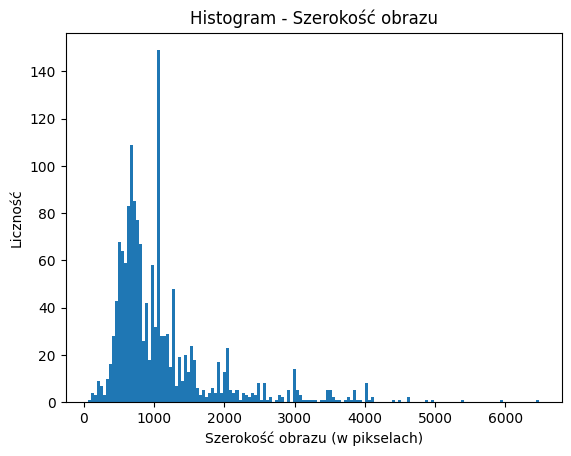

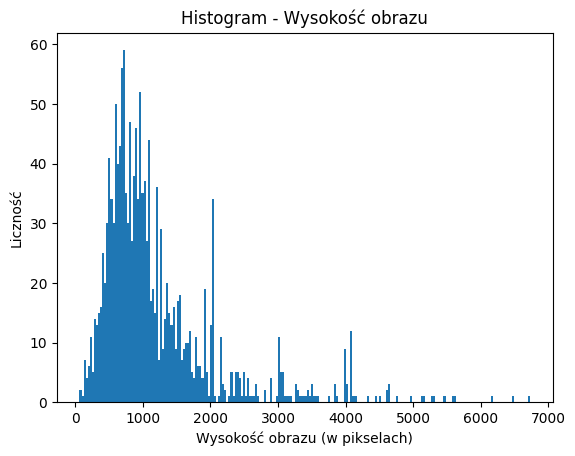

In [ ]:
if not os.path.isfile(PROCESSED_DATASET_JSON):
  dataframe = pd.read_csv(RAW_DATASET_CSV)
  image_widths, image_heights = PrepareDataset(dataframe, RAW_DATASET_IMGS, PROCESSED_DATASET_JSON, PROCESSED_DATASET_IMGS)
  analyze_images(image_widths, image_heights)

## Loading processed dataset

In [ ]:
# Dataset must be processed before
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, img_dir, tools):
        self.df = dataframe
        self.img_dir = img_dir
        self.tools = tools
        self.img_dict = self.__preload_images() # dict[img_name] = pil_image

    def __preload_images(self):
        os.makedirs(TMP_DIR, exist_ok = True)
        secret_path = os.path.join(TMP_DIR, "__data")
        if os.path.isfile(secret_path): return LoadBin(secret_path)
        loop = tqdm( self.df.iterrows(), total = len(self.df) )
        output = dict()
        for index, row in loop:
            img_name = row[IMG_HEADER]
            image = Image.open(os.path.join(self.img_dir, img_name))
            output[img_name] = image
        SaveBin(output, secret_path)
        return output

    def get_label(self, index):
        return self.df.iloc[index][self.tools.labels].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx][IMG_HEADER]
        image = self.img_dict[img_name]
        image = self.tools.AugmentImage(image)
        text = self.df.iloc[idx][TEXT_HEADER]
        labels = self.get_label(idx)
        return image, text, labels

In [ ]:
class TorchDataset(Dataset):
    def __init__(self, multimodal_dataset, image_model, text_model, fft_model):
        self.multimodal_dataset = multimodal_dataset
        self.image_model = image_model
        self.text_model = text_model
        self.fft_model = fft_model

    def __len__(self):
        return len(self.multimodal_dataset)

    def __getitem__(self, idx):
        image, text, labels = self.multimodal_dataset[idx]
        torch_image = self.image_model.normalize(image)
        torch_image_for_fft = self.fft_model.normalize(image)
        torch_encodings = self.text_model.tokenize(text)
        return torch_image, torch_image_for_fft, torch_encodings, np.array(labels).astype(float)

In [ ]:
generator = torch.Generator().manual_seed(RANDOM_SEED)

multimodal = MultimodalDataset(pd.read_json(PROCESSED_DATASET_JSON, lines=True), PROCESSED_DATASET_IMGS, TOOLS) # PROCESSED_DATASET_IMGS
dataset = TorchDataset(multimodal, IMAGE_MODEL, TEXT_MODEL, FFT_MODEL)

def TrainTestSplit(dataset):
    train_size = int(TRAIN_VS_VAL_SPLIT * len(dataset))
    test_size = len(dataset) - train_size
    train_set, test_set = TorchRandomSplit(dataset, [train_size, test_size], generator=generator)
    return train_set, test_set

train, test = TrainTestSplit(dataset)

TRAIN_LOADER = DataLoader(train, batch_size = TOOLS.batch_size, shuffle = True)
TEST_LOADER = DataLoader(test, batch_size = TOOLS.batch_size, shuffle = False)

print(f'Training set size: {len(train)}')
print(f'Test set size: {len(test)}')

Training set size: 1156
Test set size: 386


In [ ]:
def GetDatasetInfo(dataset, labels, threshold = 0.5):
  d = dict()
  for i in range(len(labels)): d[labels[i]] = 0
  loop = tqdm( range( len(dataset) ), total=len(dataset) )
  for idx in loop:
    lab = dataset.get_label(idx)
    for i in range(len(lab)):
      if lab[i] > threshold:
        d[labels[i]] = d[labels[i]] + 1
  return d

def GetWeights(dataset, labels, threshold = 0.5):
  d = GetDatasetInfo(dataset, labels, threshold)
  total_samples = len(dataset)
  inverse_freqs = [ total_samples / (d[labels[i]]) for i in range(len(labels)) ]
  sum_inverse_freqs = sum(inverse_freqs)
  return [freq / sum_inverse_freqs for freq in inverse_freqs]

WEIGHTS = torch.tensor(GetWeights(multimodal, LABELS), device=DEVICE)
print()
print(WEIGHTS)

100%|██████████| 1542/1542 [00:01<00:00, 819.77it/s]



tensor([0.0697, 0.0658, 0.0552, 0.2065, 0.1617, 0.2213, 0.1525, 0.0672],
       device='cuda:0')


## Labels analysis

100%|██████████| 1542/1542 [00:01<00:00, 1381.64it/s]


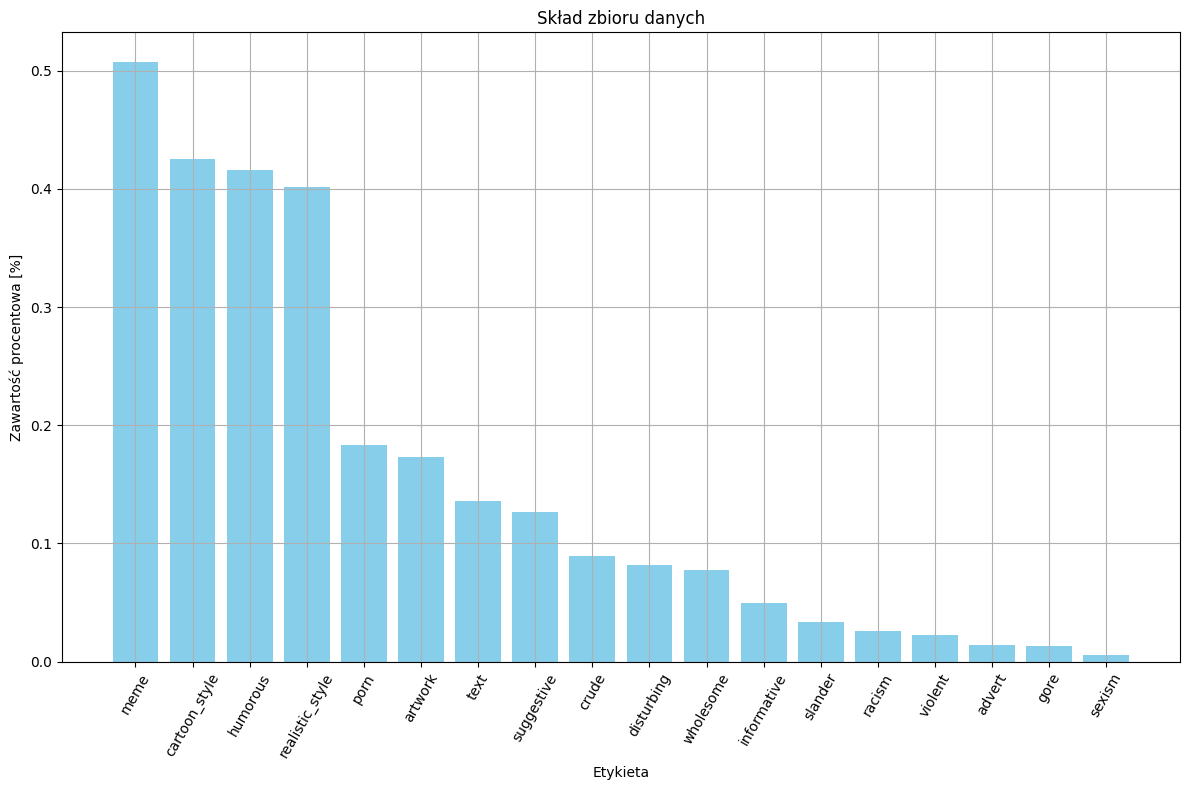

In [ ]:
def analyze_labels(dataset, labels):
  quantities = GetDatasetInfo(dataset, labels)
  for label in quantities:
    quantities[label] = quantities[label] / len(dataset)
  plt.figure(figsize=(12, 8))
  z = [ ( key, quantities[key] ) for key in quantities ]
  z = sorted(z, key=lambda x: x[1], reverse=True)
  l = [ i[0] for i in z ]
  c = [ i[1] for i in z ]
  plt.bar(l, c, color='skyblue')
  plt.xlabel("Etykieta")
  plt.ylabel("Zawartość procentowa [%]")
  plt.title("Skład zbioru danych")
  plt.xticks(rotation=60)
  plt.tight_layout()
  plt.grid()
  plt.show()
analyze_labels(multimodal, LABELS)

In [ ]:
def get_label_correlation(dataset, labels, threshold = 0.5):
  data = dict()
  for l_label_id in range(len(labels)):
    for r_label_id in range(l_label_id+1, len(labels)):
      l_label = labels[l_label_id]
      r_label = labels[r_label_id]
      combination = f"{l_label}\n{r_label}"
      data[combination] = (0, l_label, r_label)
      for i in range(len(dataset)):
        lab = dataset.get_label(i)
        if lab[l_label_id] > threshold and lab[r_label_id] > threshold:
          data[combination] = (data[combination][0] + 1, l_label, r_label)
  data = [ (key, data[key]) for key in data ]
  return data
def analyze_label_correlation(dataset, labels):
  quantities = GetDatasetInfo(dataset, labels)
  correlation = get_label_correlation(dataset, labels)
  results = []
  for combined_labels, d in correlation:
    num, l_label, r_label = d
    l_label_num = quantities[l_label]
    r_label_num = quantities[r_label]
    correlation_percent = (num / min(l_label_num, r_label_num))
    results.append( (combined_labels, correlation_percent) )
  results = sorted(results, key=lambda x: x[1], reverse=True)
  results = results[:15]
  names = [ i[0] for i in results ]
  values = [ i[1] for i in results ]
  plt.figure(figsize=(12, 8))
  plt.bar(names, values, color='skyblue')
  plt.title("Poziom skorelowania par etykiet")
  plt.xlabel("Pary etykiet")
  plt.ylabel("Poziom skorelowania [%]")
  plt.xticks(rotation=60)
  plt.tight_layout()
  plt.grid()
  plt.show()
analyze_label_correlation(multimodal, LABELS)

100%|██████████| 1542/1542 [00:01<00:00, 1240.82it/s]


KeyboardInterrupt: 

In [ ]:

def get_label_correlation(dataset, labels, threshold=0.5):
    data = dict()
    for l_label_id in range(len(labels)):
        for r_label_id in range(l_label_id + 1, len(labels)):
            l_label = labels[l_label_id]
            r_label = labels[r_label_id]
            combination = f"{l_label}\n{r_label}"
            data[combination] = (0, l_label, r_label)
            for i in range(len(dataset)):
                lab = dataset.get_label(i)
                if lab[l_label_id] > threshold and lab[r_label_id] > threshold:
                    data[combination] = (data[combination][0] + 1, l_label, r_label)
    data = [(key, data[key]) for key in data]
    return data

def analyze_label_correlation(dataset, labels):
    quantities = GetDatasetInfo(dataset, labels)
    correlation = get_label_correlation(dataset, labels)
    results = []

    for combined_labels, d in correlation:
        num, l_label, r_label = d
        l_label_num = quantities[l_label]
        r_label_num = quantities[r_label]
        correlation_percent = (num / min(l_label_num, r_label_num))
        results.append((combined_labels, num, l_label_num, r_label_num, correlation_percent))

    # Sort results by correlation factor in descending order
    results = sorted(results, key=lambda x: x[4], reverse=True)

    # Generate LaTeX table
    latex_table = "\\begin{table}[H]\n\\centering\n\\begin{tabular}{|c|c|c|c|c|}\n\\hline\n"
    latex_table += "Para etykiet & Liczność & Etykieta 1 & Etykieta 2 & Korelacja \\\\\n\\hline\n"

    for combined_labels, num, l_label_num, r_label_num, correlation_percent in results:
        combined_labels = combined_labels.replace("\n", ", ")
        line = f"{combined_labels} & {num} & {l_label_num} & {r_label_num} & {correlation_percent:.2f}" +" \\\\\n\\hline\n"
        line = line.replace("_", "\_")
        latex_table += line

    latex_table += "\\end{tabular}\n\\caption{Korelacja etykiet}\n\\end{table}"

    print(latex_table)

analyze_label_correlation(multimodal, LABELS)


In [ ]:
def analyze_label_num(dataset):
  all_num = []
  for i in range(len(dataset)):
    l = dataset.get_label(i)
    num = sum(l)
    all_num.append(num)
  return np.min(all_num), np.mean(all_num), np.std(all_num), np.max(all_num)
print(analyze_label_num(multimodal))

## Text analysis

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

100%|██████████| 1542/1542 [00:21<00:00, 70.21it/s]



Samples containing text: 1174/1542 [76.13%]
Text length in tokens: min 1, avg 46.04, std 82.76, max 2224
Unique tokens=6856, total=54055, diversity=0.127


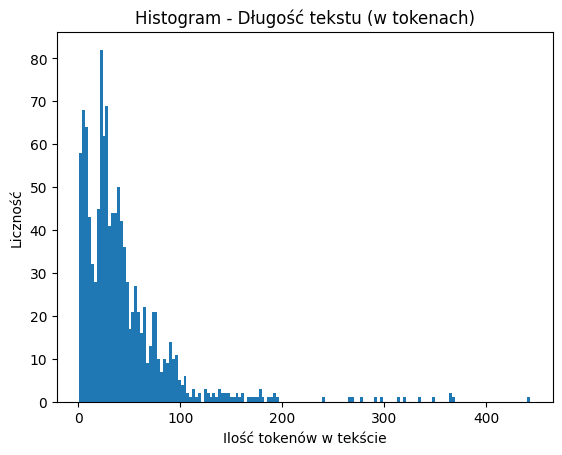

In [ ]:
def analyze_texts(dataset, tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased")):
  loop = tqdm(range( len(dataset) ), total=len(dataset))
  has_text = 0
  lengths = []
  all_tokens = []
  for idx in loop:
    _, text, _ = dataset[idx]
    tokens = tokenizer.tokenize(text)
    if len(tokens) > 0:
      has_text = has_text + 1
      lengths.append( len(tokens) )
      all_tokens.extend(tokens)
  lengths = np.array(lengths)
  min_length = np.min(lengths)
  max_length = np.max(lengths)
  average = np.mean(lengths)
  stddev = np.std(lengths)
  total_tokens = len(all_tokens)
  unique_tokens = len(set(all_tokens))
  diversity = unique_tokens / total_tokens
  has_text_percentage = (has_text / len(dataset)) * 100
  # Statistics
  print()
  print(f"Samples containing text: {has_text}/{len(dataset)} [{has_text_percentage:.2f}%]")
  print(f"Text length in tokens: min {min_length}, avg {average:.2f}, std {stddev:.2f}, max {max_length}")
  print(f"Unique tokens={unique_tokens}, total={total_tokens}, diversity={diversity:.3f}")
  # Visualization
  lengths = np.array(lengths)
  lengths = lengths[lengths<=600] # A BODGE FOR VISUALIZATION!
  plt.figure()
  plt.hist(lengths, bins=len(set(lengths)))
  plt.title("Histogram - Długość tekstu (w tokenach)")
  plt.xlabel("Ilość tokenów w tekście")
  plt.ylabel("Liczność")
  plt.show()
analyze_texts(multimodal)

100%|██████████| 1542/1542 [00:18<00:00, 81.19it/s]



Token length in characters: min 1, avg 3.06, std 1.75, max 14


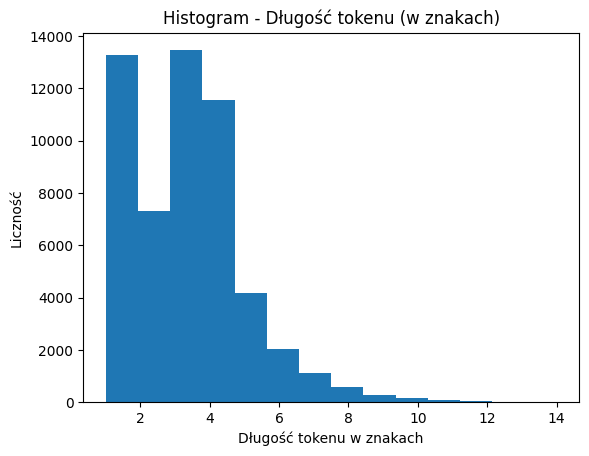

In [ ]:
def analyze_tokens(dataset, tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased")):
  loop = tqdm(range( len(dataset) ), total=len(dataset))
  lengths = []
  for idx in loop:
    _, text, _ = dataset[idx]
    tokens = tokenizer.tokenize(text)
    for token in tokens:
      lengths.append(len(token))
  lengths = np.array(lengths)
  min_length = np.min(lengths)
  max_length = np.max(lengths)
  average = np.mean(lengths)
  stddev = np.std(lengths)
  # Statistics
  print()
  print(f"Token length in characters: min {min_length}, avg {average:.2f}, std {stddev:.2f}, max {max_length}")
  # Visualization
  plt.figure()
  plt.hist(lengths, bins=len(set(lengths)))
  plt.title("Histogram - Długość tokenu (w znakach)")
  plt.xlabel("Długość tokenu w znakach")
  plt.ylabel("Liczność")
  plt.show()
analyze_tokens(multimodal)

# **Classifier model**

---



In [ ]:
IMAGE_PCA = PCA_Transform(FEATURES_SIZE, TRAIN_LOADER, lambda data: IMAGE_MODEL(data[0].to(DEVICE)) )
print(f"Image variance explained: {IMAGE_PCA.total_variance_ratio()}")
TEXT_PCA = PCA_Transform(FEATURES_SIZE, TRAIN_LOADER, lambda data: TEXT_MODEL(data[2].to(DEVICE)) )
print(f"Text variance explained: {TEXT_PCA.total_variance_ratio()}")
FFT_PCA = PCA_Transform(FEATURES_SIZE, TRAIN_LOADER, lambda data: FFT_MODEL(data[1].to(DEVICE)) )
print(f"FFT variance explained: {FFT_PCA.total_variance_ratio()}")

100%|██████████| 37/37 [00:29<00:00,  1.26it/s]


Image variance explained: 0.9833711981773376


100%|██████████| 37/37 [00:25<00:00,  1.45it/s]


Text variance explained: 0.9997891187667847


100%|██████████| 37/37 [00:22<00:00,  1.66it/s]


FFT variance explained: 1.0


In [ ]:
class Classifier(nn.Module):
  def __init__(self, num_labels, image_model, image_pca, text_model, text_pca, fft_model, fft_pca):
    super(Classifier, self).__init__()
    self.image_model = image_model
    self.image_pca = image_pca
    self.text_model = text_model
    self.text_pca = text_pca
    self.fft_model = fft_model
    self.fft_pca = fft_pca
    self.classifier = nn.Sequential(
        nn.Dropout(p = 0.25),
        nn.Linear(in_features = FEATURES_SIZE*2, out_features = 512, bias = True),
        nn.ReLU(),
        #nn.Dropout(p = 0.25),
        #nn.Linear(in_features = 512, out_features = 512, bias = True),
        #nn.ReLU(),
        nn.Dropout(p = 0.25),
        nn.Linear(in_features = 512, out_features = num_labels, bias = True)
    )

  def __max_tensors(self, tensors_tuple):
    output = tensors_tuple[0]
    for tensor in tensors_tuple[1:]: output = torch.max(output, tensor)
    return output

  def normalize_features(self, feature_tuple):
    return tuple([ nn.functional.normalize(f, p=2, dim=1) for f in feature_tuple ])

  def merge_features(self, feature_tuple):
    return torch.cat(feature_tuple, dim=1) # concatenation
    #return self.__max_tensors(feature_tuple) # max value for each feature
    #return torch.stack(feature_tuple).mean(dim=0) # average

  def forward(self, image, image_for_fft, encodings):
    image_features = self.image_model(image)
    image_features = self.image_pca(image_features)
    text_features = self.text_model(encodings)
    text_features = self.text_pca(text_features)
    #fft_features = self.fft_model(image_for_fft)
    #fft_features = self.fft_pca(fft_features)
    feature_tuple = self.normalize_features( tuple([image_features, text_features]) )
    features = self.merge_features( feature_tuple )
    return self.classifier(features)

# **Training loop**

---



In [ ]:
epochs = 50
learning_rate = 0.0004
gamma = 0.98
model_title = "RESNET50 + DistilRoBERTa"

## Metrics & co

In [ ]:
def compute_metrics(targets, outputs, thresholds, num_labels):
  auc_scores = []
  f1_scores = []
  for i in range(num_labels):
    y, y_scores = targets[:,i], outputs[:,i]
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_true=y, y_score=y_scores)
    auc = sklearn.metrics.auc(x=fpr, y=tpr)
    auc_scores.append(auc)
    y_pred = np.where(y_scores > thresholds[i], 1, 0)
    f1 = sklearn.metrics.f1_score(y, y_pred)
    f1_scores.append(f1)
  return auc_scores, f1_scores

def compute_optimal_thresholds(targets, outputs, num_labels, iota = 0.00001):
  label_thresholds = []
  for i in range(num_labels):
    y, y_scores = targets[:,i], outputs[:,i]
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y, y_scores)
    optimal_idx = np.argmax( 2 *(precision*recall)/(precision+recall+iota) )
    optimal_threshold = thresholds[optimal_idx]
    label_thresholds.append(optimal_threshold)
  return label_thresholds

def plot_chart(history, title, xlabel, ylabel, labels, offset, key, epoch, avg):
  plt.figure(figsize=(15, 10))
  for i in range(len(labels)):
    val = [ row[key][i+offset] for row in history ]
    plt.plot(epoch, val, label=labels[i])
  plt.plot(epoch, avg, label="Średnia")
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.grid()
  plt.legend(loc='lower right')
  plt.show()

def plot_history(model_title, history, labels):
  epoch = [ i+1 for i in range(len(history)) ]
  # Loss chart
  train_loss = [ row['train_loss'] for row in history ]
  test_loss = [ row['test_loss'] for row in history ]
  plt.figure(figsize=(15, 10))
  plt.plot(epoch, train_loss, label="Zbiór uczący")
  plt.plot(epoch, test_loss, label="Zbiór testowy")
  plt.xlabel("Epoka")
  plt.ylabel("Średnia wartość funkcji straty")
  plt.title(f"{model_title}: Wartość funkcji straty w zależności od epoki")
  plt.grid()
  plt.legend(loc='lower right')
  plt.show()
  # AUC chart
  avg_auc = [ sum(row['auc']) / len(labels) for row in history ]
  plot_chart(history, f"{model_title}: Wartość AUC w zależności od epoki", "Epoka", "Wartość AUC", labels[:int(len(labels)/2)], 0, 'auc', epoch, avg_auc)
  plot_chart(history, f"{model_title}: Wartość AUC w zależności od epoki", "Epoka", "Wartość AUC", labels[int(len(labels)/2):], int(len(labels)/2), 'auc', epoch, avg_auc)
  # F1 chart
  avg_f1 = [ sum(row['f1']) / len(labels) for row in history ]
  plot_chart(history, f"{model_title}: Wartość F1-score w zależności od epoki", "Epoka", "F1-score", labels[:int(len(labels)/2)], 0, 'f1', epoch, avg_f1)
  plot_chart(history, f"{model_title}: Wartość F1-score w zależności od epoki", "Epoka", "F1-score", labels[int(len(labels)/2):], int(len(labels)/2), 'f1', epoch, avg_f1)

def update_history(history, labels): # Bodge
  h = copy.deepcopy(history)
  for epoch in h:
    targets = epoch['targets']
    outputs = epoch['outputs']
    thresholds = compute_optimal_thresholds(targets, outputs, len(labels))
    p, r, aupr, f1 = [], [], [], []
    for i in range(len(labels)):
      y, y_scores = targets[:,i], outputs[:,i]
      y_pred = np.where(y_scores > thresholds[i], 1, 0)
      p.append(sklearn.metrics.precision_score(y_true=y, y_pred=y_pred))
      r.append(sklearn.metrics.recall_score(y_true=y, y_pred=y_pred))
      f1.append( sklearn.metrics.f1_score(y_true=y, y_pred=y_pred) )
      aupr.append( sklearn.metrics.average_precision_score(y_true=y, y_score=y_scores) )
    epoch['precision'] = p
    epoch['recall'] = r
    epoch['aupr'] = aupr
    epoch['f1'] = f1
  return h

def convert_history_to_metrics_dict(hist, priority = 'f1', depth = 5):
  h = sorted(hist, key=lambda x: sum(x[priority]) / len(x[priority]), reverse = True)
  h = h[:depth]
  metrics_dict = dict()
  for i in range(len(LABELS)):
    label = LABELS[i]
    auc = [ epoch['auc'][i] for epoch in h ]
    auc = sum(auc) / len(auc)
    f1 = [ epoch['f1'][i] for epoch in h ]
    f1 = sum(f1) / len(f1)
    precision = [ epoch['precision'][i] for epoch in h ]
    precision = sum(precision) / len(precision)
    recall = [ epoch['recall'][i] for epoch in h ]
    recall = sum(recall) / len(recall)
    aupr = [ epoch['aupr'][i] for epoch in h ]
    aupr = sum(aupr) / len(aupr)
    metrics_dict[label] = { 'auc':auc, 'f1':f1, 'precision':precision, 'recall':recall, 'aupr':aupr }
  return metrics_dict

def metrics_table(metrics_dict):
  latex_table = "\\begin{table}[h!]\n\\centering\n\\begin{tabular}{|c|c|c|c|c|c|}\n\\hline\n"
  latex_table += "Etykieta & AUC & Precision & Recall & F1 & AUPR \\\\\n\\hline\n"

  for label, metrics in metrics_dict.items():
      latex_table += f"{label} & {metrics['auc']:.3f} & {metrics['precision']:.3f} & {metrics['recall']:.3f} & { metrics['f1']:.3f} & {metrics['aupr']:.3f} \\\\\n"

  average_auc = np.mean([v['auc'] for v in metrics_dict.values()])
  average_precision = np.mean([v['precision'] for v in metrics_dict.values()])
  average_recall = np.mean([v['recall'] for v in metrics_dict.values()])
  average_f1 = np.mean([v['f1'] for v in metrics_dict.values()])
  average_aupr = np.mean([v['aupr'] for v in metrics_dict.values()])
  latex_table += "\\hline\n"
  latex_table += f"Średnia & {average_auc:.3f} & {average_precision:.3f} & {average_recall:.3f} & {average_f1:.3f} & {average_aupr:.3f} \\\\\n"
  latex_table += "\\hline\n"
  latex_table += "\\end{tabular}\n\\caption{Metrics per label}\n\\label{tab:metrics}\n\\end{table}"
  return latex_table

## Functions, loop

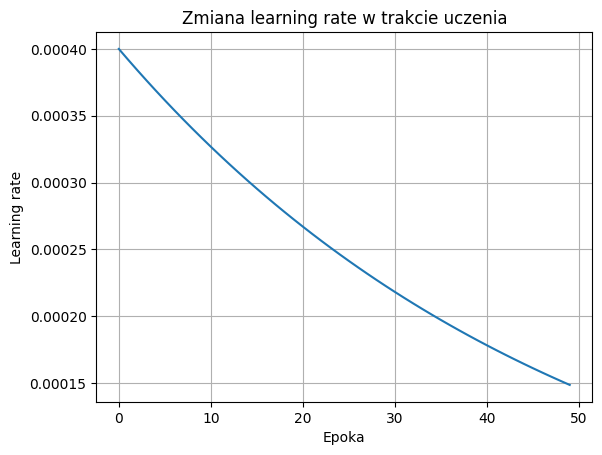

In [ ]:
plt.figure()
X = [ i for i in range(epochs) ]
Y = [ learning_rate * (gamma**i) for i in range(epochs) ]
plt.plot(X,Y)
plt.xlabel("Epoka")
plt.ylabel("Learning rate")
plt.title("Zmiana learning rate w trakcie uczenia")
plt.grid()
plt.show()

In [ ]:
model = Classifier(len(LABELS), IMAGE_MODEL, IMAGE_PCA, TEXT_MODEL, TEXT_PCA, FFT_MODEL, FFT_PCA ).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
criterion = nn.BCEWithLogitsLoss(weight = WEIGHTS)
activation = nn.Sigmoid()

In [ ]:
def train_step(epoch, model, optimizer, criterion, activation, loader):
  model.train()
  loop = tqdm(loader)
  losses = 0.0
  all_targets = []
  all_outputs = []
  for idx, data in enumerate(loop):
    image, image_for_fft, encodings, labels = data
    image, image_for_fft, encodings, labels = image.to(DEVICE), image_for_fft.to(DEVICE), encodings.to(DEVICE), labels.to(DEVICE)
    optimizer.zero_grad()
    outputs = model(image, image_for_fft, encodings)
    loss = criterion(outputs, labels)
    all_targets.append( labels.cpu().numpy() )
    all_outputs.append( activation(outputs).cpu().detach().numpy() )
    loss.backward()
    optimizer.step()
    losses = losses + loss.item()
    loop.set_postfix(epoch=epoch, loss = loss.item())
  average_loss = losses / len(loader)
  all_targets = np.concatenate(all_targets, axis=0)
  all_outputs = np.concatenate(all_outputs, axis=0)
  return average_loss, all_targets, all_outputs

def test_step(epoch, model, criterion, activation, loader):
  model.eval()
  with torch.no_grad():
    all_targets = []
    all_outputs = []
    loop = tqdm(loader)
    losses = 0.0
    for idx, data in enumerate(loop):
      image, image_for_fft, encodings, labels = data
      image, image_for_fft, encodings, labels = image.to(DEVICE), image_for_fft.to(DEVICE), encodings.to(DEVICE), labels.to(DEVICE)
      outputs = model(image, image_for_fft, encodings)
      loss = criterion(outputs, labels)
      all_targets.append( labels.cpu().numpy() )
      all_outputs.append( activation(outputs).cpu().numpy() )
      losses = losses + loss.item()
      loop.set_postfix(epoch=epoch, test_loss = loss.item())
    average_loss = losses / len(loader)
    all_targets = np.concatenate(all_targets, axis=0)
    all_outputs = np.concatenate(all_outputs, axis=0)
    return average_loss, all_targets, all_outputs

history = []
for epoch in range(epochs):
  train_loss, train_targets, train_outputs = train_step(epoch+1, model, optimizer, criterion, activation, TRAIN_LOADER)
  thresholds = compute_optimal_thresholds(train_targets, train_outputs, len(LABELS))
  test_loss, targets, outputs = test_step(epoch+1, model, criterion, activation, TEST_LOADER)
  auc, f1 = compute_metrics(targets, outputs, thresholds, len(LABELS))
  scheduler.step()
  print(f"Epoch {epoch+1}: avg_train_loss={train_loss:.3f}, avg_test_loss={test_loss:.3f}, auc={sum(auc)/len(auc) :.3f}, f1={sum(f1)/len(f1) :.3f}")
  history.append( {'train_loss':train_loss, 'test_loss':test_loss, 'auc':auc, 'f1':f1, 'targets':targets, 'outputs':outputs} ) # f1 from here isn't used

In [ ]:
SaveBin(history, f"{model_title}.history")

## Results

In [ ]:
history = LoadBin(f"{model_title}.history")
history = update_history(history, LABELS)

In [ ]:
plot_history(model_title, history, LABELS)

In [ ]:
print(metrics_table(convert_history_to_metrics_dict(history)))

In [ ]:
from google.colab import runtime
runtime.unassign()

# **Development's sandbox**

---



## FFT ResNet + Tiny ImageNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import requests
import zipfile
from PIL import Image
from torchvision.transforms.v2 import ToPILImage
import tqdm
from matplotlib import pyplot as plt
from sklearn import metrics
import torch.nn.functional as F

In [ ]:
# Function to download and extract Tiny ImageNet
def download_tiny_imagenet(data_dir='./data'):
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
    zip_path = os.path.join(data_dir, 'tiny-imagenet-200.zip')
    if not os.path.exists(zip_path):
        print('Downloading Tiny ImageNet...')
        response = requests.get(url, stream=True)
        with open(zip_path, 'wb') as f:
            f.write(response.content)
        print('Download complete.')

    extract_dir = os.path.join(data_dir, 'tiny-imagenet-200')
    if not os.path.exists(extract_dir):
        print('Extracting Tiny ImageNet...')
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print('Extraction complete.')

In [ ]:
# Custom Dataset to apply Fourier Transform
class FFTDataset(Dataset):
    def __init__(self, root, train=True, transform=None, fourier = True, augment = False):
        self.root = os.path.join(root, 'tiny-imagenet-200', 'train' if train else 'val')
        self.transform = transform
        self.augment = augment
        self.fourier = fourier
        self.images = []
        self.labels = []

        if train:
            for class_dir in os.listdir(self.root):
                class_path = os.path.join(self.root, class_dir, 'images')
                for img_name in os.listdir(class_path):
                    self.images.append(os.path.join(class_path, img_name))
                    self.labels.append(class_dir)
        else:
            val_annotations = os.path.join(self.root, 'val_annotations.txt')
            with open(val_annotations, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    self.images.append(os.path.join(self.root, 'images', parts[0]))
                    self.labels.append(parts[1])

        self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(set(self.labels)))}
        self.labels = [self.class_to_idx[label] for label in self.labels]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        label = F.one_hot(torch.tensor(label), num_classes = 200).double()
        image = Image.open(img_path).convert('RGB')
        if self.transform: image = self.transform(image)
        if self.augment: image = self.augment(image)
        return image, label

In [ ]:
data_dir = './data'
download_tiny_imagenet(data_dir)

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

augment = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.33),
    transforms.RandomVerticalFlip(p=0.33),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(1, 1.1)),
    #transforms.RandomApply([AddGaussianNoise(mean=0, std=0.1)], p=0.25),
])

In [ ]:
class FFTResnet(nn.Module):
  def __init__(self, num_classes):
    super(FFTResnet, self).__init__()
    self.resnet = models.resnet18(pretrained=False, num_classes = num_classes)
    self.resnet.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Normalize((0.5), (0.5)),
    ])
    self.normalization = (0.003469, 0.007588, 0.00162, 1.8142) # mag_avg, mag_std, ang_avg, ang_std

  def __fourier_transform(self, img):
      img_tensor = img
      img_tensor = torch.fft.fft2(img_tensor, norm="forward")
      magnitude = torch.abs(img_tensor)
      phase = torch.angle(img_tensor)
      if self.normalization:
        mag_avg, mag_std, ang_avg, ang_std = self.normalization
        magnitude = (magnitude - mag_avg) / mag_std
        phase = (phase - ang_avg) / ang_std
      return torch.cat([magnitude, phase], dim=0)

  def __batched_fourier(self, batch_tensor):
    B = batch_tensor.shape[0]
    results = []
    for i in range(B):
        result = self.__fourier_transform(batch_tensor[i])
        results.append(result)
    batch_result = torch.stack(results)
    return batch_result

  def compute_normalization(self, images): # images should be pillow images
    self.normalization = None
    all_magnitudes = []
    all_phases = []
    for image in images:
      m, p =  self.__fourier_transform(self.normalize(image))
      all_magnitudes.append(m)
      all_phases.append(p)
    all_magnitudes = np.concatenate(all_magnitudes, axis = 0)
    all_phases = np.concatenate(all_phases, axis = 0)
    self.normalization = (np.mean(all_magnitudes), np.std(all_magnitudes), np.mean(all_phases), np.std(all_phases))

  def normalize(self, image):
    return self.transform(image)

  def forward(self, x):
    x = self.__batched_fourier(x)
    return self.resnet(x)


In [ ]:
resnet = FFTResnet(200)
print(resnet.normalization)
trainset = FFTDataset(root=data_dir, train=True, transform=None, fourier=False)
resnet.compute_normalization( ( trainset[i][0] for i in range(len(trainset)) ) )
print(resnet.normalization)

In [ ]:
def compute_metrics(targets, outputs, thresholds, num_labels):
  auc_scores = []
  f1_scores = []
  acc_scores = []
  top_acc_scores = []
  for i in range(num_labels):
    y, y_scores = targets[:,i], outputs[:,i]
    fpr, tpr, _ = metrics.roc_curve(y_true=y, y_score=y_scores)
    auc = metrics.auc(x=fpr, y=tpr)
    auc_scores.append(auc)
    y_pred = np.where(y_scores > thresholds[i], 1, 0)
    f1 = metrics.f1_score(y, y_pred)
    f1_scores.append(f1)
    acc = metrics.accuracy_score(y, y_pred)
    acc_scores.append(acc)
  indices = np.argmax(targets, axis=1)
  top_acc = metrics.top_k_accuracy_score(indices, outputs, k=5)
  return auc_scores, f1_scores, acc_scores, top_acc

def compute_optimal_thresholds(targets, outputs, num_labels):
  label_thresholds = []
  for i in range(num_labels):
    y, y_scores = targets[:,i], outputs[:,i]
    fpr, tpr, thresholds = metrics.roc_curve(y_true=y, y_score=y_scores)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    label_thresholds.append(optimal_threshold)
  return label_thresholds


In [ ]:
def plot_history(history, labels):
  epoch = [ i+1 for i in range(len(history)) ]
  # Loss chart
  train_loss = [ row['train_loss'] for row in history ]
  test_loss = [ row['test_loss'] for row in history ]
  plt.figure()
  plt.plot(epoch, train_loss, label="Train loss")
  plt.plot(epoch, test_loss, label="Test loss")
  plt.xlabel("epoch")
  plt.ylabel("average loss")
  plt.title("Loss(epoch)")
  plt.legend(loc='lower right')
  plt.show()
  # AUC chart
  plt.figure()
  #for i in range(len(labels)):
  #  auc = [ row['auc'][i] for row in history ]
  #  plt.plot(epoch, auc, label=labels[i])
  avg_auc = [ sum(row['auc']) / len(labels) for row in history ]
  plt.plot(epoch, avg_auc, label="Average")
  plt.xlabel("epoch")
  plt.ylabel("AUC")
  plt.title("AUC(epoch)")
  plt.legend(loc='lower right')
  plt.show()
  # F1 chart
  plt.figure()
  #for i in range(len(labels)):
  #  auc = [ row['f1'][i] for row in history ]
  #  plt.plot(epoch, auc, label=labels[i])
  avg_f1 = [ sum(row['f1']) / len(labels) for row in history ]
  plt.plot(epoch, avg_f1, label="Average")
  plt.xlabel("epoch")
  plt.ylabel("F1-score")
  plt.title("F1(epoch)")
  plt.legend(loc='lower right')
  plt.show()
  # ACC chart
  plt.figure()
  #for i in range(len(labels)):
  #  auc = [ row['acc'][i] for row in history ]
  #  plt.plot(epoch, auc, label=labels[i])
  avg_acc = [ sum(row['acc']) / len(labels) for row in history ]
  plt.plot(epoch, avg_acc, label="Average")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.title("ACC(epoch)")
  plt.legend(loc='lower right')
  plt.show()
  avg_acc = [ row['top_acc'] for row in history ]
  plt.plot(epoch, avg_acc, label="Average")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.title("Top5ACC(epoch)")
  plt.legend(loc='lower right')
  plt.show()

In [ ]:

# Main function to train the model
def train_model(model):

    history = []
    history_targets = []
    history_logits = []

    train_dataset = FFTDataset(root=data_dir, train=True, transform=model.normalize, augment = augment)
    val_dataset = FFTDataset(root=data_dir, train=False, transform=model.normalize)

    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        loop = tqdm.tqdm(train_loader)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            loop.set_postfix(epoch = epoch, loss = loss.item())

        scheduler.step()
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        model.eval()
        val_loss = 0.0
        all_targets = []
        all_logits = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                all_targets.append( labels.cpu().numpy() )
                all_logits.append( outputs.cpu().numpy() )
        all_targets = np.concatenate(all_targets, axis=0)
        history_targets.append(all_targets)
        all_logits = np.concatenate(all_logits, axis=0)
        history_logits.append(all_logits)

        thresholds = compute_optimal_thresholds(all_targets, all_logits, 200)
        auc, f1, acc, top_acc = compute_metrics(all_targets, all_logits, thresholds, 200)

        val_loss = val_loss / len(val_loader.dataset)

        history.append( {'train_loss':epoch_loss, 'test_loss':val_loss, 'auc':auc, 'f1':f1, 'acc':acc, 'top_acc':top_acc} )

        print(f'Validation Loss: {val_loss:.4f}, AUC: {sum(auc)/len(auc) :.4f}, F1: {sum(f1)/len(f1) :.4f}, ACC: {sum(acc)/len(acc) :.4f}, Top5ACC: {top_acc}')

    print('Training complete.')
    return history, history_targets, history_logits

resnet = FFTResnet(200)
history, history_targets, history_logits = train_model(resnet)
plot_history(history, [i for i in range(200)])

In [ ]:
import pickle
import zlib

def SaveBin(ob, filename):
    with open(filename, "wb") as handle:
        dump = pickle.dumps(ob)
        dump = zlib.compress(dump)
        handle.write(dump)

def LoadBin(filename):
    with open(filename, "rb") as handle:
        dump = handle.read()
        dump = zlib.decompress(dump)
        return pickle.loads(dump)

In [ ]:
import torch
from google.colab import files

# Assuming 'model' is your PyTorch model
torch.save(resnet.state_dict(), 'model.pth')
SaveBin(history_targets, "targets.pickle")
SaveBin(history_logits, "logits.pickle")

# Download the file 'model.pth'
files.download('model.pth')
files.download('targets.pickle')
files.download('logits.pickle')
